In [1]:
!pip install wfdb


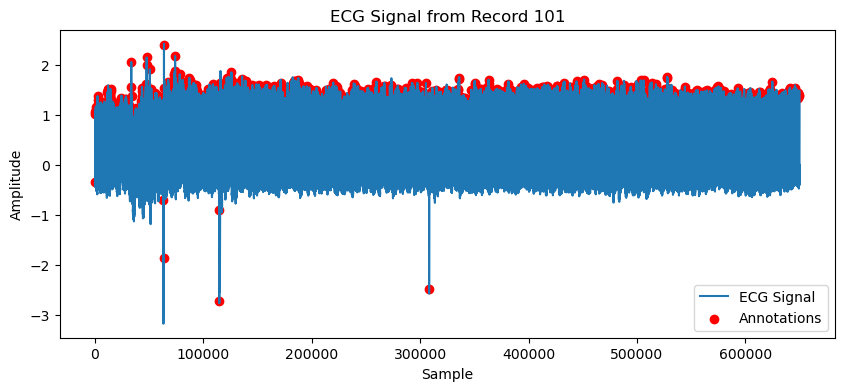

In [21]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Specify the record you want to load
record_name = '101'  # Change this to the record you want to load

# Load the record and annotation
record = wfdb.rdrecord(record_name, pn_dir='mitdb')
annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')

# Extract the signal and annotation
ecg_signal = record.p_signal
annotations = annotation.sample

# Plot the ECG signal with annotations
plt.figure(figsize=(10, 4))
plt.plot(ecg_signal[:, 0], label='ECG Signal')
plt.scatter(annotations, ecg_signal[annotations, 0], color='red', label='Annotations')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'ECG Signal from Record {record_name}')
plt.legend()
plt.show()


In [3]:
len(ecg_signal)

650000

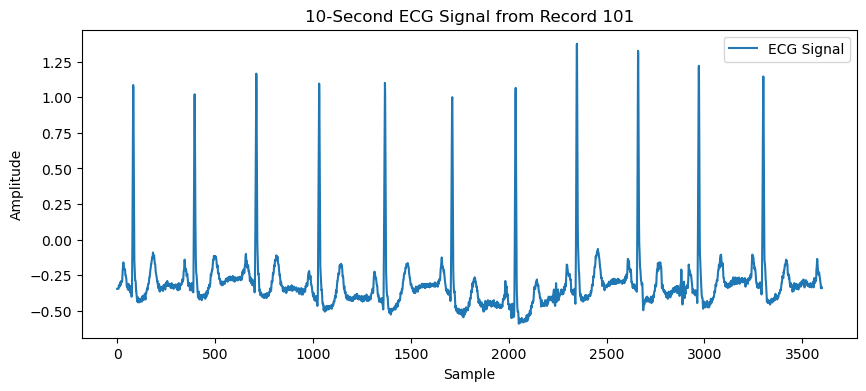

In [22]:
ecg_signal = record.p_signal[:, 0]
r_peaks = annotation.sample
# Define the duration and calculate the number of samples for 10 seconds
duration = 10  # seconds
sampling_rate = 360  # Hz
num_samples = duration * sampling_rate

# Extract the first 10 seconds of data
ecg_segment = ecg_signal[:num_samples]
r_peaks_segment = r_peaks[r_peaks < num_samples]

# Plot the 10-second ECG signal with annotations
plt.figure(figsize=(10, 4))
plt.plot(ecg_segment, label='ECG Signal')

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(f'10-Second ECG Signal from Record {record_name}')
plt.legend()
plt.show()